In [0]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri May 31 21:39:36 2019

@author: olyna

https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720
"""

import os, shutil
import urllib.request
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.layers import Dense, GlobalMaxPooling2D, Dropout,Convolution2D, MaxPooling2D, Activation, Flatten, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from matplotlib import pyplot
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.client import device_lib
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels
get_ipython().run_line_magic('matplotlib', 'inline')



def reporthook(blocknum, blocksize, totalsize):
    readsofar = blocknum * blocksize
    if totalsize > 0:
        percent = readsofar * 1e2 / totalsize
        s = "\rDownloaded %5.1f%% %*d / %d" % (
            percent, len(str(totalsize)), readsofar, totalsize)
        print(s, end='')
        if readsofar >= totalsize: # near the end
            print("\n")
    else: # total size is unknown
        print("read %d\n" % (readsofar,))
        

def plot_confusion_matrix(y_test, y_pred, labels_categ, xlabels=None, normalize=False,
                          title=None, cmap=plt.cm.Blues):
    '''
    This function can plot conf.matrces which are not quadratic. In this, you just have to
    provide target names for x-axis, which are different of y_pred labels. But in thiw case,
    classification report has no sense, only support is usefull.'''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
            
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(cm.shape)
    # Only use the labels that appear in the data
    classes = [labels_categ[i] for i in unique_labels(y_test, y_pred)]
    
    # If labels on x axis are different than y-axis
    if xlabels == None:
      xticklabels = classes
    else:
      xticklabels = xlabels
      cm = cm[:, :len(xlabels)] # Change cm x-axis dimensions
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=xticklabels, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return(ax)
  
  
def evaluateModel(history, model, test_generator):
  pyplot.plot(history.history['loss'], label='train-loss')
  pyplot.plot(history.history['val_loss'], label='val-loss')
  pyplot.legend()
  pyplot.show()

  pyplot.plot(history.history['acc'], label='train-acc')
  pyplot.plot(history.history['val_acc'], label='val-acc')
  pyplot.legend()
  pyplot.show()

  scores = model.evaluate_generator(test_generator) 
  print("Test_loss = {}\nTest_acc = {}".format(scores[0], scores[1]))
  return(0)


def predictEvaluate(test_generator, model, xlabels=None):
  '''
  Calls plot_confusion_matrix() function. Created just to avoid code duplication.'''
  # Predict Kastoria with Model_1
  step_size_test = test_generator.n//test_generator.batch_size
  test_generator.reset()
  pred = model.predict_generator(test_generator, steps=step_size_test, verbose=1)

  predicted_class_indices=np.argmax(pred, axis=1)

  # Extract labels as string
  labels = (test_generator.class_indices)
  print(labels)
  target_names = list(labels.keys())  # values are the corresponding class indices

  #Confusion Matrix and Classification Report
  plot_confusion_matrix(test_generator.classes, predicted_class_indices, labels_categ=target_names, xlabels=xlabels)

  print('\nClassification Report')
  print(classification_report(test_generator.classes, predicted_class_indices, target_names=target_names))
  return(target_names)




device_lib.list_local_devices()

# Change current working directory
cwd = os.getcwd()
os.chdir(cwd)

In [3]:
# Download EuroSAT dataset and unzip
eurosat_data_url = 'http://madm.dfki.de/files/sentinel/EuroSAT.zip'
urllib.request.urlretrieve(eurosat_data_url, 'eurosat.zip', reporthook)
print('Download Completed \n')
os.system('unzip eurosat.zip')
os.system('ls')

Downloaded 100.0% 94281728 / 94280567

Download Completed 



0

**EuroSAT ImageDataGenerators**

In [4]:
# Train/Test/Validation split
imagesEuroSat = glob.glob('2750/*/*.jpg')
print('ALL IMAGES: {}'.format(len(imagesEuroSat)))

# Test is 30% of data. trainNval are the rest 70%
trainNval, im_test = train_test_split(imagesEuroSat, train_size=0.7, random_state=2019)
print('TEST: {}'.format(len(im_test)))

if not os.path.exists('test/'):
  os.makedirs('test/')
for im in im_test:
  p, fn = os.path.split(im)
  _, cat = os.path.split(p)
  if not os.path.exists(os.path.join('test', cat)):
    os.makedirs(os.path.join('test', cat))
  shutil.move(im, os.path.join('test', cat, fn))
    
      
# Train is 70% of data - 20%of70% from validation
im_train, im_val = train_test_split(trainNval, train_size=0.8, random_state=2019)
print('TRAIN: {}'.format(len(im_train)))
print('VALIDATION: {}'.format(len(im_val)))
      
if not os.path.exists('train/'):
  os.makedirs('train/')
for im in im_train:
  p, fn = os.path.split(im)
  _, cat = os.path.split(p)
  if not os.path.exists(os.path.join('train', cat)):
    os.makedirs(os.path.join('train', cat))
  shutil.move(im, os.path.join('train', cat, fn))
      
if not os.path.exists('val/'):
  os.makedirs('val/')
for im in im_val:
  p, fn = os.path.split(im)
  _, cat = os.path.split(p)
  if not os.path.exists(os.path.join('val', cat)):
    os.makedirs(os.path.join('val', cat))
  shutil.move(im, os.path.join('val', cat, fn))
  
  
# Feed data to ImageDataGenerator
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input) 
train_generatorEuroSat = train_datagen.flow_from_directory(cwd+'/train',
                                             target_size=(224,224),
                                             color_mode='rgb',
                                             batch_size=32,
                                             class_mode='categorical',
                                             shuffle=True)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input) 
valid_generatorEuroSat = valid_datagen.flow_from_directory(cwd+'/val',
                                            target_size=(224, 224),
                                            color_mode="rgb",
                                            batch_size=32,
                                            class_mode="categorical",
                                            shuffle=True)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input) 
test_generatorEuroSat = test_datagen.flow_from_directory(cwd+'/test',
                                            target_size=(224, 224),
                                            color_mode="rgb",
                                            batch_size=1,
                                            class_mode="categorical",
                                            shuffle=False)

step_size_train = train_generatorEuroSat.n//train_generatorEuroSat.batch_size
step_size_valid = valid_generatorEuroSat.n//valid_generatorEuroSat.batch_size

ALL IMAGES: 27000
TEST: 8100
TRAIN: 15120
VALIDATION: 3780
Found 15120 images belonging to 10 classes.
Found 3780 images belonging to 10 classes.
Found 8100 images belonging to 10 classes.


**MODEL_1**

In [5]:
####  MODEL_1 - TRANSFER LEARNING

# Import CNN pretrained model and discard the fully connected layers
base_model = VGG16(weights='imagenet',include_top=False)
base_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 2s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_____

In [6]:
# Add layers to base-model
x = base_model.output  # Select the last layer of base model
x = GlobalMaxPooling2D()(x)  # Add pooling layer - gives tensor with dimensions of 1xChannels
x = Dropout(0.15)(x)       # from keras.regularizers import l2 kernel_regularizer=l2(0.01)
x = Dense(12, activation='relu')(x)  # dense layer 1. Don't need to use input_shape layer
out = Dense(10, activation='softmax')(x) #final layer 4 with softmax activation

# Make a model based on the architecture we have provided
model1 = Model(inputs=base_model.input, outputs=out)

# Untrainable layers
for layer in model1.layers[:-2]:
    layer.trainable = False
    
# Trainable layers
for layer in model1.layers[-2:]:
    print(layer)
    layer.trainable = True

opt = Adam(lr=1e-3)
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
#print(model1.summary())

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
# Train Model_1
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=15)
mc = ModelCheckpoint('my_best_model1.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

history1 = model1.fit_generator(generator = train_generatorEuroSat, verbose=1,
                   steps_per_epoch = step_size_train,
                   validation_data = valid_generatorEuroSat,
                   validation_steps = step_size_valid,
                   epochs=27,
                   callbacks=[es, mc])

Instructions for updating:
Use tf.cast instead.
Epoch 1/27
119/119 [==============================] - 20s 170ms/step - loss: 1.5221 - acc: 0.4743

Epoch 00001: val_acc improved from -inf to 0.47434, saving model to my_best_model1.h5
473/473 [==============================] - 106s 225ms/step - loss: 2.0847 - acc: 0.3369 - val_loss: 1.5221 - val_acc: 0.4743
Epoch 2/27
119/119 [==============================] - 19s 161ms/step - loss: 1.1823 - acc: 0.5902

Epoch 00002: val_acc improved from 0.47434 to 0.59021, saving model to my_best_model1.h5
473/473 [==============================] - 96s 204ms/step - loss: 1.3709 - acc: 0.5378 - val_loss: 1.1823 - val_acc: 0.5902
Epoch 3/27
119/119 [==============================] - 19s 162ms/step - loss: 0.8765 - acc: 0.7177

Epoch 00003: val_acc improved from 0.59021 to 0.71772, saving model to my_best_model1.h5
473/473 [==============================] - 96s 204ms/step - loss: 1.0607 - acc: 0.6554 - val_loss: 0.8765 - val_acc: 0.7177
Epoch 4/27
119/119

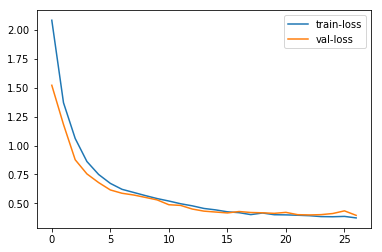

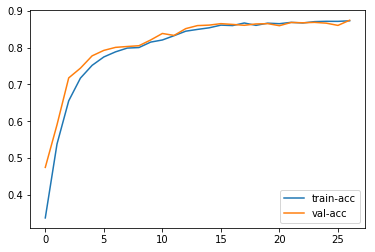

Test_loss = 0.3885039302524057
Test_acc = 0.8713580369949341


0

In [8]:
# Evaluate Model_1 (Plots loss, acc etc)
evaluateModel(history1, model1, test_generatorEuroSat)

8100/8100 [==============================] - 84s 10ms/step
{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}
(10, 10)
Confusion matrix, without normalization

Classification Report
                      precision    recall  f1-score   support

          AnnualCrop       0.91      0.91      0.91       921
              Forest       0.94      0.95      0.95       890
HerbaceousVegetation       0.82      0.84      0.83       922
             Highway       0.74      0.82      0.78       765
          Industrial       0.89      0.88      0.88       742
             Pasture       0.84      0.88      0.86       598
       PermanentCrop       0.82      0.74      0.78       754
         Residential       0.93      0.93      0.93       894
               River       0.85      0.77      0.81       732
             SeaLake       0.95      0.96      0.96       882

            accura

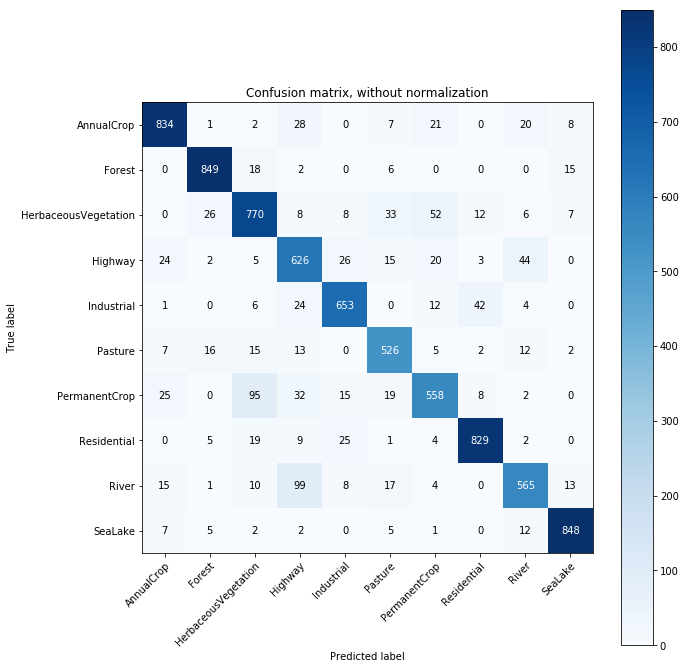

In [9]:
# Plot Classification  Report and Confusion Matrix for EuroSAT dataset with Model_1
targNamesEuroSAT = predictEvaluate(test_generatorEuroSat, model1)

**MODEL_2**

In [12]:
####  MODEL 2 - CONVOLUTIONAL NEURAL NETWORKS

# Build model
model2 = Sequential()
model2.add(Convolution2D(8, (3, 3), input_shape=(224, 224, 3), activation = 'relu',padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Convolution2D(10, (3, 3), activation = 'relu',padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Convolution2D(12, (3, 3), activation = 'relu',padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Convolution2D(14, (3, 3), activation = 'relu',padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Convolution2D(16, (3, 3), activation = 'relu', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())
model2.add(Dropout(0.4))
model2.add(Dense(12, activation = 'relu'))
model2.add(Dropout(0.2))
model2.add(Dense(10, activation = 'softmax'))

opt = Adam(lr=1e-3)
model2.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model2.summary()


# Train Model_2
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=15)
mc = ModelCheckpoint('my_best_model2.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

history2 = model2.fit_generator(generator = train_generatorEuroSat, verbose=1,
                   steps_per_epoch = step_size_train,
                   validation_data = valid_generatorEuroSat,
                   validation_steps = step_size_valid,
                   epochs=27,
                   callbacks=[es, mc])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 8)       224       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 224, 224, 8)       32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 10)      730       
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 112, 112, 10)      40        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 12)        1092      
__________

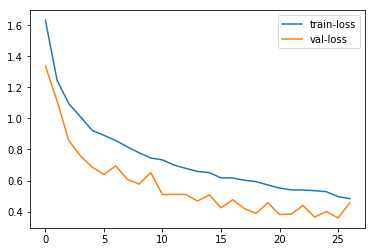

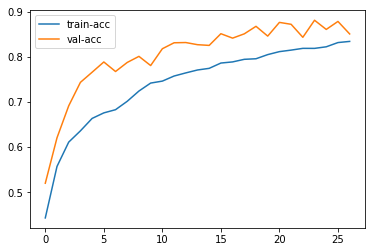

Test_loss = 0.44223038448872215
Test_acc = 0.8532098531723022


0

In [13]:
# Evaluate Model_2 (Plots loss, acc etc)
evaluateModel(history2, model2, test_generatorEuroSat)

8100/8100 [==============================] - 24s 3ms/step
{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}
(10, 10)
Confusion matrix, without normalization

Classification Report
                      precision    recall  f1-score   support

          AnnualCrop       0.79      0.90      0.84       921
              Forest       1.00      0.74      0.85       890
HerbaceousVegetation       0.75      0.86      0.80       922
             Highway       0.87      0.74      0.80       765
          Industrial       0.88      0.99      0.93       742
             Pasture       0.79      0.85      0.82       598
       PermanentCrop       0.70      0.84      0.77       754
         Residential       0.99      0.96      0.98       894
               River       0.91      0.63      0.74       732
             SeaLake       0.93      0.99      0.96       882

            accurac

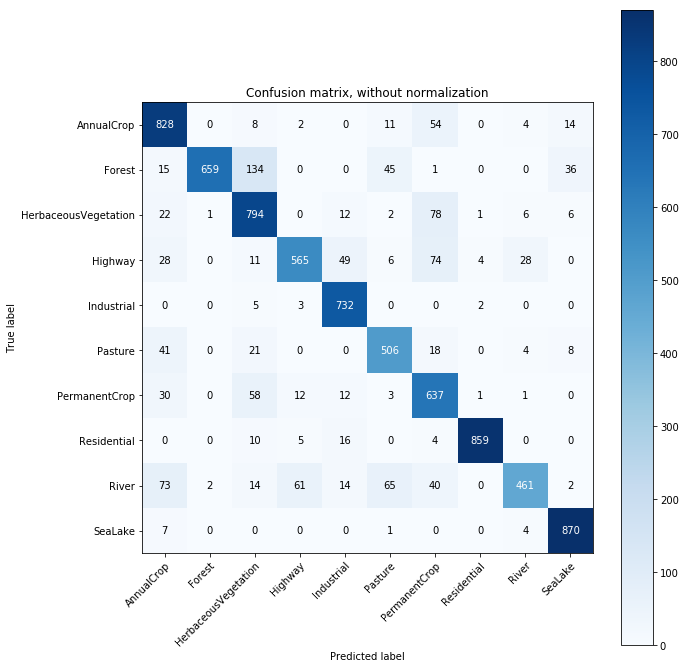

In [14]:
# Plot Classification  Report and Confusion Matrix for EuroSAT dataset with Model_2
targNamesEuroSAT = predictEvaluate(test_generatorEuroSat, model2)


**Create folders in filesystem, for KASTORIA**


Current working directory is : /content


/usr/local/lib/python3.6/dist-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'decode_packbits'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/usr/local/lib/python3.6/dist-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'decode_lzw'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/usr/local/lib/python3.6/dist-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'unpack_ints'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/usr/local/lib/python3.6/dist-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'reverse_bitorder'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))


Assume than 'zero value' is for pixels without ground truth.
Found classes are 26 : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
Saving images in directory : /content/All_Data/DenseUrbanFabric
Total pixels for this category: 2501
Saving images in directory : /content/All_Data/SparseUrbanFabric
Total pixels for this category: 303
Saving images in directory : /content/All_Data/IndustrialCommercialUnits
Total pixels for this category: 201
Saving images in directory : /content/All_Data/RoadNetworkAsphalt
Total pixels for this category: 1835
Saving images in directory : /content/All_Data/PhotovoltaicUnits
Total pixels for this category: 1474
Saving images in directory : /content/All_Data/BroadLeavedForest
Total pixels for this category: 5513
Saving images in directory : /content/All_Data/ConiferousForest
Total pixels for this category: 1759
Saving images in directory : /content/All_Data/NaturalGrasslands
Total pixels for this category: 1185
Saving images 

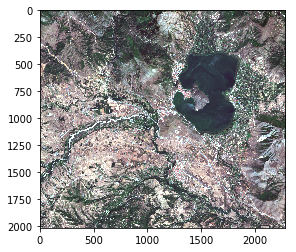

In [11]:
from script3_kastoria_windows import PrepareWindows
from matplotlib import pyplot as plt


kastoriaWins = PrepareWindows('KASTORIA_BGR_id13.tif', 'Kast_RefData_26Classes.tif', (64, 64))
smallRefim = kastoriaWins.my_classes()

labelsKast = [ 'DenseUrbanFabric', 'SparseUrbanFabric', 'IndustrialCommercialUnits',
      'RoadNetworkAsphalt', 'PhotovoltaicUnits',
      'BroadLeavedForest', 'ConiferousForest', 'NaturalGrasslands',
      'DenseSclerophyllousVegetation', 'SparselyVegetatedAreas',
      'Vineyards', 'FruitTrees', 'Wheat', 'OtherCereals', 'Maize', 'Chickpea',
      'Lentil', 'Potato', 'Beans', 'OtherVegetables', 'Clover', 'Alfalfa',
      'BeachesDunesSands', 'BareRocks', 'InlandMarshes', 'WaterBodies']

my_date = kastoriaWins.save_windows(2000, (0, 3), smallRefim, labelsKast) # ImageID = 13

plt.imshow(my_date, interpolation='nearest')
plt.show()

**ImageDataGenerator for Kastoria (only test set)**

In [12]:
# Test generator for Kastoria. Train and Val are not needed.
imagesKast = glob.glob('All_Data/*/*.jpg')
print('ALL IMAGES: {}'.format(len(imagesKast)))

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input) 
test_generatorKast = test_datagen.flow_from_directory(cwd+'/All_Data',
                                            target_size=(224, 224),
                                            color_mode="rgb",
                                            batch_size=1,
                                            class_mode="categorical",
                                            shuffle=False)

ALL IMAGES: 32349
Found 32349 images belonging to 26 classes.


In [0]:
# Load Previous Models
from tensorflow.keras.models import load_model

model1 = load_model('my_best_model1.h5')
model2 = load_model('my_best_model2.h5')

32349/32349 [==============================] - 335s 10ms/step
{'Alfalfa': 0, 'BareRocks': 1, 'BeachesDunesSands': 2, 'Beans': 3, 'BroadLeavedForest': 4, 'Chickpea': 5, 'Clover': 6, 'ConiferousForest': 7, 'DenseSclerophyllousVegetation': 8, 'DenseUrbanFabric': 9, 'FruitTrees': 10, 'IndustrialCommercialUnits': 11, 'InlandMarshes': 12, 'Lentil': 13, 'Maize': 14, 'NaturalGrasslands': 15, 'OtherCereals': 16, 'OtherVegetables': 17, 'PhotovoltaicUnits': 18, 'Potato': 19, 'RoadNetworkAsphalt': 20, 'SparseUrbanFabric': 21, 'SparselyVegetatedAreas': 22, 'Vineyards': 23, 'WaterBodies': 24, 'Wheat': 25}
(26, 26)
Confusion matrix, without normalization

Classification Report
                               precision    recall  f1-score   support

                      Alfalfa       0.01      0.00      0.00      2000
                    BareRocks       0.00      0.00      0.00       182
            BeachesDunesSands       0.01      0.14      0.02       728
                        Beans       0.13    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


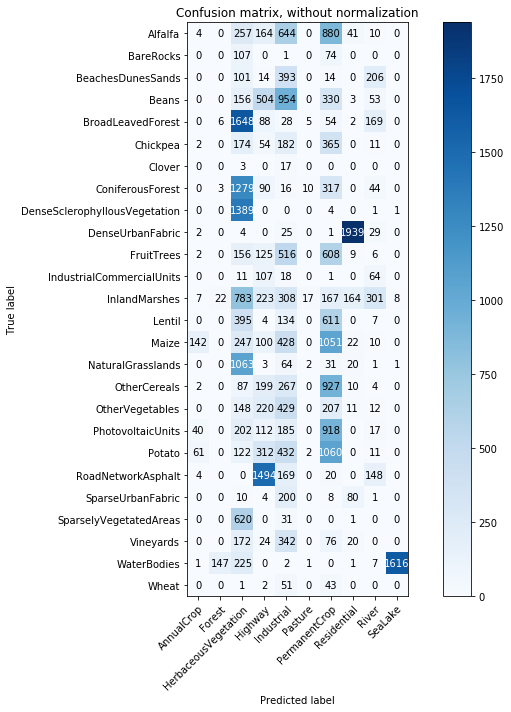

In [13]:
# Plot 'Classification Report' and Confusion Matrix for Kastoria dataset with Model_1
targNames = predictEvaluate(test_generatorKast, model1, xlabels=targNamesEuroSAT)

32349/32349 [==============================] - 93s 3ms/step
{'Alfalfa': 0, 'BareRocks': 1, 'BeachesDunesSands': 2, 'Beans': 3, 'BroadLeavedForest': 4, 'Chickpea': 5, 'Clover': 6, 'ConiferousForest': 7, 'DenseSclerophyllousVegetation': 8, 'DenseUrbanFabric': 9, 'FruitTrees': 10, 'IndustrialCommercialUnits': 11, 'InlandMarshes': 12, 'Lentil': 13, 'Maize': 14, 'NaturalGrasslands': 15, 'OtherCereals': 16, 'OtherVegetables': 17, 'PhotovoltaicUnits': 18, 'Potato': 19, 'RoadNetworkAsphalt': 20, 'SparseUrbanFabric': 21, 'SparselyVegetatedAreas': 22, 'Vineyards': 23, 'WaterBodies': 24, 'Wheat': 25}
(26, 26)
Confusion matrix, without normalization

Classification Report
                               precision    recall  f1-score   support

                      Alfalfa       0.00      0.00      0.00      2000
                    BareRocks       0.00      0.00      0.00       182
            BeachesDunesSands       0.00      0.00      0.00       728
                        Beans       0.00      

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


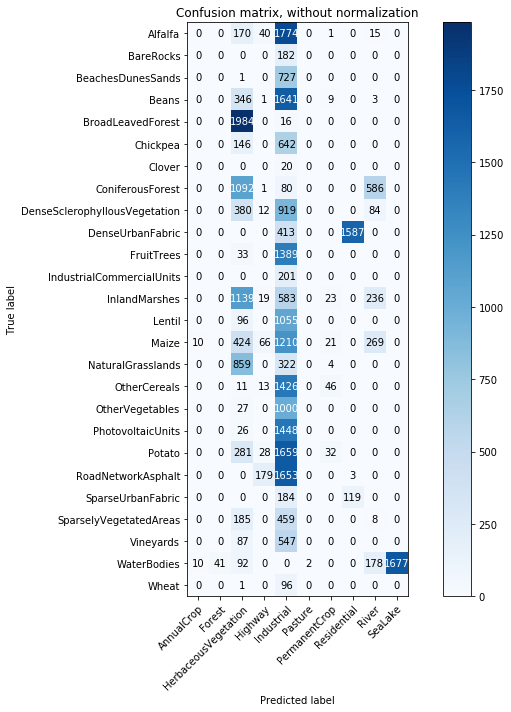

In [17]:
# Plot 'Classification Report' and Confusion Matrix for Kastoria dataset with Model_2
targNames = predictEvaluate(test_generatorKast, model2, xlabels=targNamesEuroSAT)